In [1]:
%load_ext autoreload
%autoreload 2
!which python
%env CUDA_VISIBLE_DEVICES=6

/home/guandao/tava/env/tava/bin/python
env: CUDA_VISIBLE_DEVICES=6


In [2]:
import torch
import os
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from tava.utils.training import resume_from_ckpt
from tava.models.basic.mipnerf import cylinder_to_gaussian

device = "cuda"

In [3]:
# # args for data
# ARGS_ANIMAL_WOLF = [
#     "dataset=animal_wolf", "dataset.root_fp=/home/ruilongli/data/forest_and_friends_rendering/",
#     "hydra.run.dir=/home/ruilongli/workspace/TAVA/outputs/release/animal_wolf/Wolf_cub_full_RM_2/snarf/",
# ]
# ARGS_ANIMAL_HARE=[
#     "dataset=animal_hare", "dataset.root_fp=/home/ruilongli/data/forest_and_friends_rendering/",
#     "hydra.run.dir=/home/ruilongli/workspace/TAVA/outputs/release/animal_hare/Hare_male_full_RM/snarf/",
# ]
# ARGS_ZJU_313=[
#     "dataset=zju", "dataset.subject_id=313", "dataset.root_fp=/home/ruilongli/data/zju_mocap/neuralbody/",
#     "hydra.run.dir=/home/ruilongli/workspace/TAVA/outputs/release/zju_mocap/313/snarf/",
# ]
# ARGS_ZJU_315=[
#     "dataset=zju", "dataset.subject_id=315", "dataset.root_fp=/home/ruilongli/data/zju_mocap/neuralbody/",
#     "hydra.run.dir=/home/ruilongli/workspace/TAVA/outputs/release/zju_mocap/315/snarf/",
# ]
# 
# # args for method
# ARGS_TAVA_ANIMAL=["pos_enc=snarf", "loss_bone_w_mult=1.0", "pos_enc.offset_net_enabled=false", "model.shading_mode=null"]
# ARGS_TAVA_ZJU=["pos_enc=snarf", "loss_bone_w_mult=1.0", "pos_enc.offset_net_enabled=true", "model.shading_mode=implicit_AO"]

# ARGS for method
project_dir = "/home/guandao/tava"
subject_id = 2
ARGS_TAVA_HUMANRF = [
    "dataset=humanrf", 
    f"dataset.subject_id={subject_id:02d}",
    "dataset.post_fix='_qual'",
    "pos_enc=snarf",
    "loss_bone_w_mult=1.0",
    "loss_bone_offset_mult=0.1",
    "engine=evaluator",
    "pos_enc.offset_net_enabled=true", 
    "model.shading_mode=implicit_AO",
    f"hydra.run.dir=/home/guandao/tava/pretrained/actor{subject_id:02d}"
]

In [4]:
# here we set the arguments for ZJU_313 as an example.
# overrides = ["resume=True"] + ARGS_ANIMAL_HARE + ARGS_TAVA_ANIMAL
overrides = ["resume=True"] + ARGS_TAVA_HUMANRF 

# create the cfg
with initialize(config_path="../configs"):
    cfg = compose(config_name="mipnerf_dyn_humanrf", overrides=overrides, return_hydra_config=True)
    OmegaConf.resolve(cfg.hydra)
    save_dir = cfg.hydra.run.dir
    ckpt_dir = os.path.join(save_dir, "checkpoints")
    
# initialize model and load ckpt
model = instantiate(cfg.model).to(device)
_ = resume_from_ckpt(
    path=ckpt_dir, model=model, step=cfg.resume_step, strict=True,
)
assert os.path.exists(ckpt_dir), "ckpt does not exist! Please check."

# initialize dataset
dataset = instantiate(
    cfg.dataset, split="train", num_rays=None, cache_n_repeat=None,
)
meta_data = dataset.build_pose_meta_info()

In [5]:
# create a color pattern for visualization
torch.manual_seed(412)
colorbases = torch.rand((cfg.dataset.n_transforms + 1, 3)) * 255

In [26]:
# As the Mip-NeRF requires a covariance for density & color querying,
# we here *estimate* a `cov` based on the size of the subject and the 
# number of sampled points. It can be estimated in other ways such as
# average of cov during training.

idx = 0
radii = dataset[0]["rays"].radii.mean().to(device)
rest_verts = torch.from_numpy(
    # dataset.parser.load_meta_data()["rest_verts"]
    dataset.parser.load_meta_data()["verts"][idx]
).to(device)
bboxs_min = rest_verts.min(dim=0).values
bboxs_max = rest_verts.max(dim=0).values
subject_size = torch.prod(bboxs_max - bboxs_min) ** (1./3.)
t0, t1 = 0, subject_size / model.num_samples
d = torch.tensor([0., 0., 1.]).to(device)
_, cov = cylinder_to_gaussian(d, t0, t1, radii, model.diag)

In [27]:
# Create a grid coordinates to be queried in canonical.

def create_grid3D(min, max, steps, device="cpu"):
    if type(min) is int:
        min = (min, min, min) # (x, y, z)
    if type(max) is int:
        max = (max, max, max) # (x, y)
    if type(steps) is int:
        steps = (steps, steps, steps) # (x, y, z)
    arrangeX = torch.linspace(min[0], max[0], steps[0]).to(device)
    arrangeY = torch.linspace(min[1], max[1], steps[1]).to(device)
    arrangeZ = torch.linspace(min[2], max[2], steps[2]).to(device)
    gridX, girdY, gridZ = torch.meshgrid([arrangeX, arrangeY, arrangeZ], indexing="ij")
    coords = torch.stack([gridX, girdY, gridZ]) # [3, steps[0], steps[1], steps[2]]
    coords = coords.view(3, -1).t() # [N, 3]
    return coords
_center = (bboxs_max + bboxs_min) / 2.0
_scale = (bboxs_max - bboxs_min) / 2.0
bboxs_min_large = _center - _scale * 1.5
bboxs_max_large = _center + _scale * 1.5
# res = 512
# res = 256
res = 128
coords = create_grid3D(bboxs_min_large, bboxs_max_large, res)

In [28]:
# Query the density grid in the canonical

from tqdm import tqdm
from tava.utils.bone import closest_distance_to_points
from tava.utils.structures import namedtuple_map

bones_rest = namedtuple_map(lambda x: x.to(device), meta_data["bones_rest"])
bones_posed = namedtuple_map(
    lambda x: x.to(device),
    meta_data["bones_posed"][idx])
pose_latent = meta_data["pose_latent"][idx].to(device)
rigid_clusters = torch.tensor(dataset.parser.RIGID_BONE_IDS).long().to(device)
bones_rest.heads.shape, bones_posed.heads.shape, pose_latent.shape, rigid_clusters.shape

(torch.Size([23, 3]), torch.Size([23, 3]), torch.Size([10]), torch.Size([23]))

In [29]:
type(model.pos_enc)
model.pos_enc.search_n_init=5

In [47]:
chunk_size = 20000 
densities = []
with torch.no_grad():
    for i in tqdm(range(0, coords.shape[0], chunk_size)):
        coords_chunk = coords[i: i + chunk_size].to(device)
        
        x_enc, x_warp, mask, valid = model.pos_enc(
            coords_chunk[None, ...], 
            cov.expand_as(coords_chunk)[None, ...], 
            bones_posed, 
            bones_rest,
            rigid_clusters=rigid_clusters,
            pose_latent=pose_latent
        )
        
        # dists = closest_distance_to_points(bones_rest, x_warp).min(dim=-1).values
        # selector = dists <= cfg.dataset.cano_dist
        _, raw_density, _ = model.mlp(
            x_enc[0], cond_extra=pose_latent, masks=mask[0])
        density = model.density_activation(raw_density + model.density_bias)
        density = torch.max(density, -2).values
        densities.append(density.cpu())
densities = torch.cat(densities, dim=0).reshape(res, res, res)
print (densities.min(), densities.max(), densities.median())

  1%|          | 1/105 [00:00<00:39,  2.61it/s]

100%|██████████| 105/105 [00:42<00:00,  2.46it/s]

tensor(3.9656e-34) tensor(907.7588) tensor(0.3133)


In [48]:
densities.max(), densities.min(), densities.shape

(tensor(907.7588), tensor(3.9656e-34), torch.Size([128, 128, 128]))

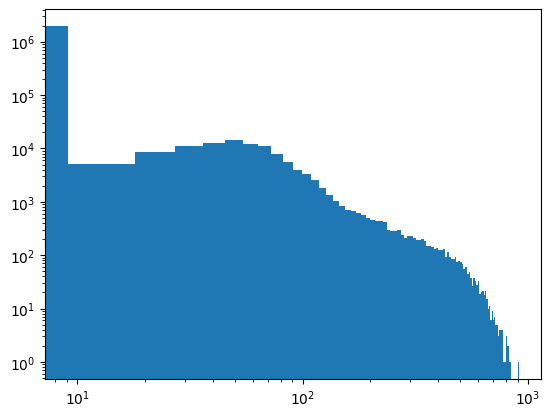

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(densities.cpu().numpy().reshape(-1), bins=100)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [50]:
type(model), type(model.mlp), cov

(tava.models.mipnerf_dyn.DynMipNerfModel,
 tava.models.basic.mlp.MLP,
 tensor([[2.5072e-08, 2.5072e-08, 1.2750e-05]], device='cuda:0'))

In [51]:
# Marching cube to get the mesh. We use the threshold 5.0 for all cases. You might want
# to adjust that with your own data. Note installing torchmcubes would take some time.

# excute this in juputer to install: "!pip install git+https://github.com/tatsy/torchmcubes.git"
from torchmcubes import marching_cubes

verts, faces = marching_cubes(densities, 5)
verts = verts[..., [2, 1, 0]] / res * (bboxs_max_large - bboxs_min_large).cpu() + bboxs_min_large.cpu()
print(verts.shape, faces.shape)

torch.Size([34038, 3]) torch.Size([67720, 3])


In [52]:
import meshplot as mp
mp.plot(verts.cpu().numpy(), faces.cpu().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4446745…